---
title: Lecture 4
subtitle: Transforms
date: 2024-09-11
downloads:
  - file: 04_lecture.ipynb
    title: 04_lecture.ipynb
  - file: ../assets/04_lecture.pdf
    title: 04_lecture.pdf
---

In [11]:
import warnings
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.fftpack import dct, idct
from scipy.linalg import hadamard
import pywt
import skimage

In [12]:
# Suppress all warnings
warnings.filterwarnings("ignore")

## DFT for images

### 1D Case

The [Fourier transform](wiki:Fourier_transform)[^1] is an integral transform that takes a function as input and outputs another function that describes the extent to which various frequencies are present in the original function. It is defined in [Definition (%s)](#def-FT) The output of the transform is a complex-valued function of frequency. 

The [IFT](wiki:Fourier_inversion_theorem) is used to transform data from the frequency domain back to the spatial domain, and is defined in [Definition (%s)](#def-IFT).

:::{prf:definition} Fourier Transform
:label: def-FT
$$
\begin{equation*}
\hat{f}(\zeta) = \int^{\infty}_{-\infty} f(x)e^{-i2\pi\zeta x} dx
\end{equation*}
$$

where,

- $\hat{f}(\zeta)$ is the frequency-domain representation of the function $f(x)$
- $\zeta$ is the frequency variable
- $f(x)$ is the original function in the spatial domain
- $x$ is the spatial variable 
:::

:::{prf:definition} IFT
:label: def-IFT
$$
\begin{equation*}
f(x) = \int_{-\infty}^{\infty} \hat{f}(\zeta) e^{i 2\pi \zeta x} \, d\zeta
\end{equation*}
$$

where,

- $\hat{f}(\zeta)$ is the frequency-domain representation of the function $f(x)$
- $\zeta$ is the frequency variable
- $f(x)$ is the reconstructed function in the spatial domain
- $x$ is the spatial variable 
:::

The [DFT](wiki:Discrete_Fourier_transform) is the Fourier transform applied to discrete data. It operates on a finite sequence of equally spaced samples, created for example by [np.linspace](#card-linspace), from a signal and is defined in [Definition (%s)](#def-DFT). The [FFT](wiki:Fast_Fourier_transform) is an efficient algorithm to compute the DFT. It reduces the computational complexity of the DFT from $O(N^2)$ to $O(N\log ⁡N)$. When using [np.fft.fft](#card-fft) the function performs the DFT via the FFT algorithm.

The IDFT is used when working with discrete data to convert the data from the frequency domain back to the time or spatial domain and is defined in [Definition (%s)](#def-IDFT).

:::{prf:definition} DFT
:label: def-DFT
$$
\begin{equation*}
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-i \frac{2\pi}{N} k n}
\end{equation*}
$$

where,

- $X[k]$ is the k-th frequency component of the input signal $x[n]$
- $k$ is the frequency index
- $x[n]$ is the signal input in the time or spatial domain
- $n$ is the sample index
:::

:::{prf:definition} IDFT
:label: def-IDFT
$$
\begin{equation*}
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \cdot e^{i \frac{2\pi}{N} k n}
\end{equation*}
$$

where,

- $x[n]$ is the n-th time or spatial domain sample of the reconstructed signal
- $n$ is the sample index in the time or spatial domain
- $X[k]$ is the k-th frequency component in the frequency domain
- $k$ is the frequency index
- $N$ is the total number of samples
:::

[^1]: An animated introduction to the Fourier Transform.
    :::{iframe} https://www.youtube.com/embed/spUNpyF58BY?si=siTxY9oE7mT2z1oX
    :::

### Example

Generate a time-domain signal by combining two sine waves with frequencies of 5 Hz and 25 Hz, respectively, and sample this signal at a rate of 500 samples per second for one second. Then, compute the DFT using the FFT algorithm and plot the magnitude spectrum to analyze the frequency components. Finally, use the IDFT to recover the original time-domain signal and plot both the original and recovered signals for comparison. 

The plots should illustrate the time-domain signal, its frequency spectrum, and the recovered signal to demonstrate the accuracy of the Fourier transformations.

### Solution

Use NumPy to generate the time domain signal.

In [2]:
# define the time domain signal
sampling_rate = 500 # samples per second
T = 1.0 / sampling_rate # seconds per sample (sampling interval)
duration = 1.0
N = int(duration * sampling_rate) # samples
x = np.linspace(0.0, duration, N, endpoint=False) # False to account for 0-index

# create a signal composed of two difference sine waves
freq1 = 5
freq2 = 25
signal = 0.5 * np.sin(2.0 * np.pi * freq1 * x) + 1 * np.sin(2.0 * np.pi * freq2 * x)

Compute the DFT. This is accomplished using [np.fft.fft](#card-fft). In addition [np.fft.fftfreq](#card-fftfreq) is used to generate frequency bins corresponding to the components of the DFT.

In [3]:
# compute the DFT using FFT
fft_values = np.fft.fft(signal)

# real-valued signals 
fft_mag = np.abs(fft_values)
freqs = np.fft.fftfreq(N, T)

:::{important}
The absolute value of the FFT result is taken because the FFT returns complex numbers, which represent both amplitude and phase information. In most cases the magnitude of the frequency components (i.e., how strong each frequency is in the signal) is of interest rather than the phase.
:::

Use the IDFT to reconstruct the signal. This is accomplished with the [np.fft.ifft](#card-ifft) function.

In [4]:
# compute the Inverse Fourier Transform using IFFT
recovered_signal = np.fft.ifft(fft_values).real # take only the real values

Plot the results.

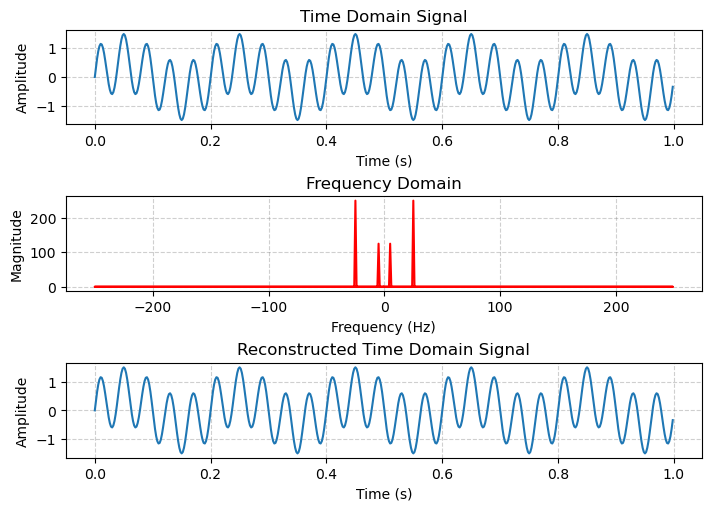

In [5]:
# plot the results
fig, axs = plt.subplots(3, 1, figsize=(7,5), layout='constrained')

# time domain signal
axs[0].plot(x, signal)
axs[0].set_title('Time Domain Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# frequency domain
axs[1].plot(freqs, fft_mag, color='red')
axs[1].set_title('Frequency Domain')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')

# reconstructed time domain signal
axs[2].plot(x, recovered_signal)
axs[2].set_title('Reconstructed Time Domain Signal')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')

# format the grid in each axes
for ax in [axs[0], axs[1], axs[2]]:
    ax.grid(True, linestyle='--', color='gray', alpha=0.375)

# show the figure
plt.show()

The time domain signal looks complex because of the superposition of two sine waves with different frequencies. In the frequency domain it is clear that the signal is composed of two frequencies (e.g., 5 Hz and 25 Hz). Lastly, the magnitude of the peaks in the frequency domain gives information on the relative strength of each frequency in the original signal.

:::{note}
When you apply the FFT to a real-valued signal, the resulting frequency components are mirrored around the zero frequency. This symmetry comes from the fact that the Fourier Transform of a real-valued signal is conjugate-symmetric. This means if you have a frequency component at a positive frequency, you will also have an identical (but mirrored) frequency component at the corresponding negative frequency.
:::

### 2D Case

The Fourier transform for 2D is an integral transform that extends the 1D case to two dimensions. It takes a 2D function as the input and outputs another function that describes the extent to which various frequencies are present in the original 2D function. The result is a complex-valued function representing the frequency domain in both dimensions and is defined in [Definition (%s)](#def-2FT).

The 2D IFT is used to transform the data from the frequency domain back to the spatial domain and is defined in [Definition (%s)](#def-2IFT).

:::{prf:definition} 2D Fourier Transform
:label: def-2FT
$$
\begin{equation*}
\hat{f}(u, v) = \int^{\infty}_{-\infty}\int^{\infty}_{-\infty}f(x,y)e^{-i2\pi (ux+uy)}\,dx\,dy
\end{equation*}
$$

where,

- $\hat{f}(u,v)$ is the frequency domain representation of the 2D function $f(x,y)$
- $u$ is the frequency variable in the horizontal direction
- $v$ is the frequency variable in the vertical direction
- $f(x,y)$ is the original function in the time or spatial domain
- $x$ and $y$ are the spatial variables
:::

:::{prf:definition} 2D IFT
:label: def-2IFT
$$
\begin{equation*}
f(x,y) = \int^{\infty}_{-\infty}\int^{\infty}_{-\infty}\hat{f}(u,v)e^{i2\pi (ux + vy)} \, du \, dv
\end{equation*}
$$

where,

- $f(x,y)$ is the reconstructed function in the spatial domain
- $\hat{f}(u,v)$ is the frequency domain representation of the original function
- $u$ and $v$ are the frequency variables in the horizontal and vertical directions
- $x$ and $y$ are the spatial variables
:::

The 2D DFT operates on a finite 2D grid of equally spaced samples, for example created from [np.meshgrid](#card-meshgrid), and is defined in [Definition (%s)](#def-2DFT). The 2D DFT can be represented in matrix form, which is commonly used in image processing. The 2D DFT is essentially two 1D DFTs: one applied along the rows, and then one applied along the columns and is defined in [Definition (%s)](#def-2DFTMat).

:::{prf:definition} 2D DFT
:label: def-2DFT
$$
\begin{equation*}
X[u, v] = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
\end{equation*}
$$

where,

- $X[u,v]$ is the frequency component of the 2D signal $f(x,y)$
- $u$ and $v$ are the frequency indices in the horizontal and vertical directions
- $f(x,y)$ is the signal input in the 2D time or spatial domain
- $x$ and $y$ are the sample indices in the horizontal and vertical directions
- $M$ and $N$ are the dimensions of the 2D array (e.g., the number of rows and columns)
:::

:::{prf:definition} 2D DFT Matrix Form
:label: def-2DFTMat
$$
\begin{equation*}
X = F_M \cdot f \cdot F^{T}_N
\end{equation*}
$$

where,

- $X$ is the matrix representing the 2D DFT for the image
- $f$ is the original 2D signal (e.g., the image)
- $F_M$ is the DFT matrix for the rows
- $F^{T}_M$ is the transpose of the DFT matrix for the columns

$F_M$ and $F_N$ can be found from the following:

$$
\begin{equation*}
F = \begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-i 2 \pi \frac{1}{n}} & e^{-i 2 \pi \frac{2}{n}} & \cdots & e^{-i 2 \pi \frac{n-1}{n}} \\
1 & e^{-i 2 \pi \frac{2}{n}} & e^{-i 2 \pi \frac{4}{n}} & \cdots & e^{-i 2 \pi \frac{2(n-1)}{n}} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-i 2 \pi \frac{n-1}{n}} & e^{-i 2 \pi \frac{2(n-1)}{n}} & \cdots & e^{-i 2 \pi \frac{(n-1)(n-1)}{n}} \\
\end{bmatrix}
\end{equation*}
$$
:::

The 2D IDFT is used to convert an image from the frequency domain back to the spatial domain to reconstruct the original signal and is defined in [Definition (%s)](#def-2DIDFT). The 2D IDFT can be expressed in matrix form and is defined in [Definition (%s)](#def-2DIDFTMat).

:::{prf:definition} 2D IDFT
:label: def-2DIDFT
$$
\begin{equation*}
f(x, y) = \frac{1}{NM} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} X(u, v) \cdot e^{i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}
\end{equation*}
$$

where,

- $f(x,y)$ is the reconstructed spatial signal
- $X(u,v)$ is the frequency domain representation of the signal
- $M$ and $N$ are the dimensions of the signal
- $u$ and $v$ are the frequency indices
- $x$ and $y$ are the spatial indices
:::

:::{prf:definition} 2D IDFT Matrix Form
:label: def-2DIDFTMat
$$
\begin{equation*}
f = \frac{1}{NM} F_M^H \cdot X \cdot F_N^H
\end{equation*}
$$

where,

- $f$ is the image in the spatial domain
- $X$ is the image in the frequency domain
- $F^{H}_M$ is the Hermitian transpose (complex conjugate transpose) of the DFT matrix for the rows
- $F^{H}_N$ is the Hermitian transpose of the DFT matrix for the columns
:::

### Example

Write a Python program that creates a 2D signal composed of two sine waves, one in the x-direction and one in the y-direction. Define the 2D grid dimensions and the frequencies of the sine waves in both directions. Use the FFT to compute the 2D DFT of the signal, then shift the zero-frequency component to the center of the frequency domain for visualization purposes. 

Plot the magnitude spectrum of the 2D DFT to analyze the frequency content of the signal. Finally, compute the 2D IDFT to recover the original 2D signal and compare it with the original signal by plotting both side by side. 

The problem should demonstrate the transition between the spatial and frequency domains using the 2D DFT and its inverse.

### Solution

Use NumPy to generate the spatial domain signal.

In [6]:
# Define the 2D signal dimensions
rows, cols = 50, 50  # 2D grid size (like an image)
x = np.linspace(0, 1, cols, endpoint=False)  # Time/spatial samples for the columns
y = np.linspace(0, 1, rows, endpoint=False)  # Time/spatial samples for the rows
X, Y = np.meshgrid(x, y)  # Create a 2D mesh grid

# Define the frequencies in both x and y directions
freq_x = 5  # Frequency in the x direction
freq_y = 7  # Frequency in the y direction

# Create a 2D signal composed of sine waves in both x and y directions
signal_2d = 0.5 * np.sin(2.0 * np.pi * freq_x * X) + 1.0 * np.sin(2.0 * np.pi * freq_y * Y)

Compute the 2D DFT. This is accomplished with [np.fft.fft2](#card-fft2). In addition, [np.fft.fftshift](#card-fftshift) is used for visualization purposes.

In [7]:
# Compute the 2D DFT using FFT
fft_values_2d = np.fft.fft2(signal_2d)

# Shift the zero-frequency component to the center for visualization purposes
fft_shifted = np.fft.fftshift(fft_values_2d)

# Compute the magnitude spectrum of the 2D FFT
fft_magnitude = np.abs(fft_shifted)

# Compute the frequency bins for both the rows and columns
freq_x = np.fft.fftshift(np.fft.fftfreq(cols))  # Frequency bins for the x-axis (columns)
freq_y = np.fft.fftshift(np.fft.fftfreq(rows))  # Frequency bins for the y-axis (rows)

# Use these frequencies to label the frequency axes
extent = [freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]]

Use the 2D IDFT to reconstruct the signal. This is accomplished with the [np.fft.ifft2](#card-ifft2) function.

:::{important} 
Applying the scaling factor shown in [Definition (%s)](#def-2DIDFTMat), $\frac{1}{NM}$, is not necessary when using [np.fft.ifft2](#card-ifft2) because NumPy handles it internally.
:::

In [8]:
# Compute the inverse 2D FFT to recover the original signal
recovered_signal_2d = np.fft.ifft2(fft_values_2d).real  # Take only the real part

Plot the results.

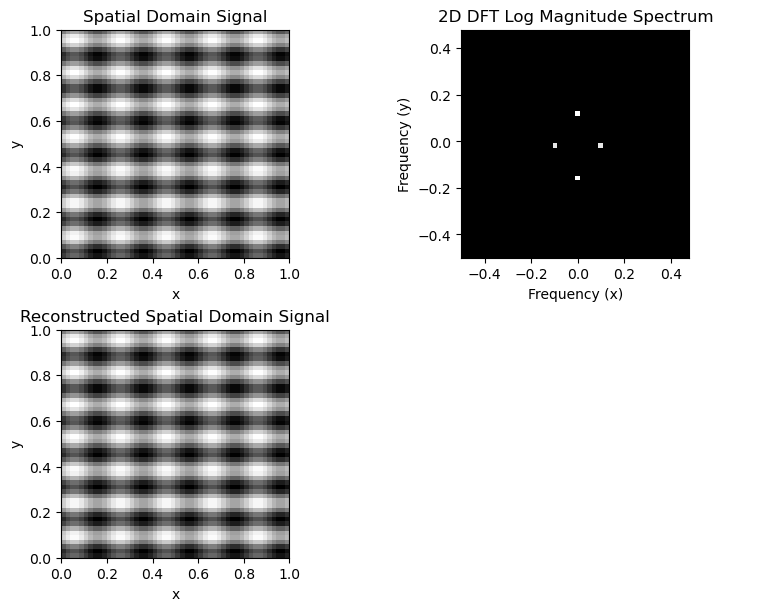

In [9]:
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(8,6), layout='constrained')

# Spatial domain function
axs[0,0].imshow(signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[0,0].set_title('Spatial Domain Signal')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

# Frequency domain
axs[0,1].imshow(np.log(fft_magnitude + 1), cmap='gray', extent=extent) # Log transform to compress the dynamic range
axs[0,1].set_title('2D DFT Log Magnitude Spectrum')
axs[0,1].set_xlabel('Frequency (x)')
axs[0,1].set_ylabel('Frequency (y)')

# Reconstructed spatial domain function
axs[1,0].imshow(recovered_signal_2d, cmap='gray', extent=[0, 1, 0, 1])
axs[1,0].set_title('Reconstructed Spatial Domain Signal')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')

# Hide the unused axes
axs[1,1].axis('off')

# show the figure
plt.show()

The original 2D signal consists of sine waves with two distinct frequencies, one in the x-direction and one in the y-direction. However, when you combine the x and y frequencies, the Fourier transform doesn't just give two spots; it reflects all the possible combinations of these frequencies, leading to four distinct bright spots.

The recovered signal (after applying the IDFT) matches the original signal very closely, indicating that the DFT and IDFT transformations are working properly.

## DCT

### 1D Case

The [DCT](wiki:Discrete_cosine_transform) is a mathematical transformation used to convert a signal or image from the spatial domain to the frequency domain using only cosine functions. It is similar to the DFT but uses only real numbers (cosines) rather than complex exponentials (sines and cosines). There are several types of DCTs, but the most common one is DCT Type-II which is show in [Definition (%s)](#def-DCT).

The IDCT is used to transform the data from the frequency domain back to the spatial domain, and is defined in [Definition (%s)](def-IDCT).

:::{prf:definition} DCT
:label: def-DCT
$$
\begin{equation*}
X[k] = \sum_{n=0}^{N-1} x[n] \cdot \cos\left( \frac{\pi}{N} \left( n + \frac{1}{2} \right) k \right)
\end{equation*}
$$

where,

- $X[k]$ is the frequency-domain representation of the 1D signal.
- $x[n]$ is the original signal in the spatial (or time) domain.
- $N$ is the length of the 1D signal.
- $k$ is the frequency index.
:::

:::{prf:definition} IDCT
:label: def-IDCT
$$
\begin{equation*}
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} \alpha(k) X[k] \cdot \cos\left( \frac{\pi}{N} \left( n + \frac{1}{2} \right) k \right)
\end{equation*}
$$

where,

- $x[n]$ is the reconstructed signal in the spatial (or time) domain.
- $X[k]$ is the frequency-domain representation of the 1D signal.
- $N$ is the length of the 1D signal.
- $n$ is the index in the spatial (or time) domain.
- $\alpha(k)$ is a normalization factor defined as:
  $$
  \alpha(k) = \begin{cases}
    1, & k = 0 \\
    2, & k > 0
  \end{cases}
  $$
:::


### Example

Generate a time-domain signal by combining two cosine waves with frequencies of 5 Hz and 25 Hz, respectively, and sample this signal at a rate of 500 samples per second for one second. Then, compute the DCT to analyze the frequency components. Finally, use the IDCT to recover the original time-domain signal and plot both the original and recovered signals for comparison.

The plots should illustrate the time-domain signal, its DCT spectrum, and the recovered signal to demonstrate the accuracy of the transformations.

### Solution

Use NumPy to generate the time-domain signal.

In [10]:
# define the time domain signal
sampling_rate = 500  # samples per second
T = 1.0 / sampling_rate  # seconds per sample (sampling interval)
duration = 1.0  # duration in seconds
N = int(duration * sampling_rate)  # number of samples
x = np.linspace(0.0, duration, N, endpoint=False)  # sample points

# create a signal composed of two different cosine waves
freq1 = 5  # 5 Hz cosine wave
freq2 = 25  # 25 Hz cosine wave
signal = 0.5 * np.cos(2.0 * np.pi * freq1 * x) + 1 * np.cos(2.0 * np.pi * freq2 * x)

Compute the DCT using [scipy.fft.dct](#card-dct). In this case, the DCT type-II is used, which is the most common version and is often referred to as simply "the DCT."

In [11]:
# compute the DCT (Type-II, which is the most commonly used DCT)
# the norm='ortho' ensures orthogonal DCT, which scales the values appropriately
dct_values = dct(signal, norm='ortho')

Use the IDCT to reconstruct the signal. This is accomplished with the [scipy.fft.idct](#card-idct) function.

:::{important}
If you use `norm='ortho'` in `scipy.ff.idct`, the function will apply the correct normalization factor for both the DCT and IDCT, so you don't need to worry about manually applying the normalization factor.
:::

In [12]:
# compute the Inverse DCT to recover the original signal
recovered_signal = idct(dct_values, norm='ortho')  # norm='ortho' for proper scaling

Plot the results.

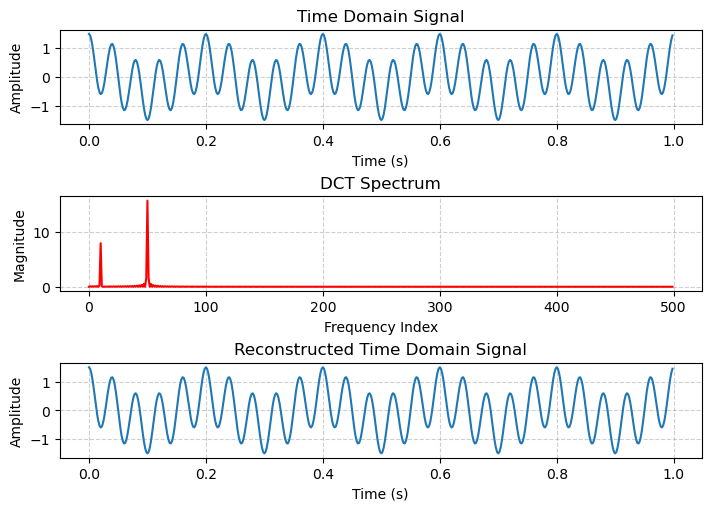

In [13]:
# Generate frequency indices for plotting (for visualization purposes)
freqs = np.arange(N)

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(7, 5), layout='constrained')

# Time domain signal
axs[0].plot(x, signal)
axs[0].set_title('Time Domain Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# DCT spectrum (plot the magnitude against frequency index)
axs[1].plot(freqs, np.abs(dct_values), color='red')  # Plot DCT magnitude
axs[1].set_title('DCT Spectrum')
axs[1].set_xlabel('Frequency Index')
axs[1].set_ylabel('Magnitude')

# Reconstructed time domain signal
axs[2].plot(x, recovered_signal)
axs[2].set_title('Reconstructed Time Domain Signal')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')

# format the grid in each axes
for ax in [axs[0], axs[1], axs[2]]:
    ax.grid(True, linestyle='--', color='gray', alpha=0.375)

# Show the figure
plt.show()

In the DCT spectrum, you should observe two prominent peaks corresponding to the frequencies of the original cosine waves (5 Hz and 25 Hz). These peaks indicate the contribution of each frequency to the original signal. The reconstructed time-domain signal should closely match the original signal, demonstrating the reversibility of the DCT.

:::{note}
Since the DCT is not complex, there is no need to account for conjugate symmetry like in the DFT. Thus, you only observe peaks corresponding to the actual frequencies present in the signal (no mirrored peaks).
:::

### 2D Case

The DCT 2D extends the 1D case to two dimensions, and is defined in [Definition (%s)](#def-2DDCT).

The 2D IDCT is used to transform the data from the frequency domain back to the spatial domain and is defined in [Definition (%s)](#def-2DIDCT).

:::{prf:definition} 2D DCT
:label: def-2DDCT
$$
\begin{equation*}
X[k_1, k_2] = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot \cos\left( \frac{\pi}{M} \left( x + \frac{1}{2} \right) k_1 \right) \cdot \cos\left( \frac{\pi}{N} \left( y + \frac{1}{2} \right) k_2 \right)
\end{equation*}
$$

where,

- $X[k_1, k_2]$ is the frequency-domain representation of the 2D signal.
- $f(x, y)$ is the original signal in the spatial domain.
- $M$ and $N$ are the dimensions of the 2D signal.
- $k_1$ and $k_2$ are the frequency indices for the x- and y-directions.
:::

:::{prf:definition} 2D IDCT
:label: def-2DIDCT
$$
\begin{equation*}
f(x, y) = \frac{4}{MN} \sum_{k_1=0}^{M-1} \sum_{k_2=0}^{N-1} \alpha(k_1) \alpha(k_2) \cdot X[k_1, k_2] \cdot \cos\left( \frac{\pi}{M} \left( x + \frac{1}{2} \right) k_1 \right) \cdot \cos\left( \frac{\pi}{N} \left( y + \frac{1}{2} \right) k_2 \right)
\end{equation*}
$$

where,

- $f(x, y)$ is the reconstructed signal in the spatial domain.
- $X[k_1, k_2]$ is the frequency-domain representation of the 2D signal.
- $M$ and $N$ are the dimensions of the 2D signal.
- $x$ and $y$ are the spatial indices for the rows and columns.
- $k_1$ and $k_2$ are the frequency indices for the x- and y-directions.
- $\alpha(k)$ is a normalization factor that is equal to:

  \begin{equation*}
  \alpha(k) = \begin{cases}
  \frac{1}{\sqrt{2}} & \text{if } k = 0 \\
  1 & \text{otherwise}
  \end{cases}
  \end{equation*}
:::

### Example

Write a Python program that constructs a 2D signal by combining two sinusoidal waves, one oriented along the x-axis and the other along the y-axis. Specify the grid size for your 2D signal as well as the frequencies for the sinusoids in both the x and y directions. Instead of using FFT, utilize the DCT to perform the 2D DCT on this signal. Shift the zero-frequency component to the center for a better visual understanding of the frequency spectrum.

Plot the magnitude spectrum resulting from the 2D DCT to evaluate the frequency components of the signal. Then, apply the 2D Inverse IDCT to reconstruct the original 2D signal, and plot both the original and the reconstructed signals side by side to compare them.

### Solution

Use NumPy to generate the 2D spatial-domain signal.

In [14]:
# Define the 2D signal dimensions
rows, cols = 50, 50  # 2D grid size (like an image)
x = np.linspace(0, 1, cols, endpoint=False)  # Time/spatial samples for the columns
y = np.linspace(0, 1, rows, endpoint=False)  # Time/spatial samples for the rows
X, Y = np.meshgrid(x, y)  # Create a 2D mesh grid

# Define the frequencies in both x and y directions
freq_x = 5  # Frequency in the x direction
freq_y = 7  # Frequency in the y direction

# Create a 2D signal composed of sine waves in both x and y directions
signal_2d = 0.5 * np.sin(2.0 * np.pi * freq_x * X) + 1.0 * np.sin(2.0 * np.pi * freq_y * Y)

Compute the 2D DCT. This is accomplished using [scipy.fftpack.dct](#card-dct). In addition, the DCT is applied in both directions (rows and columns).

In [15]:
# compute the 2D DCT using scipy's dct function
from scipy.fftpack import dct, idct

dct_values_2d = dct(dct(signal_2d.T, norm='ortho').T, norm='ortho')

# Compute the magnitude spectrum of the 2D DCT
dct_magnitude = np.abs(dct_values_2d)

Use the IDCT to reconstruct the signal. This is accomplished with the [scipy.fftpack.idct](#card-idct) function.

In [16]:
# compute the inverse 2D DCT to recover the original signal
recovered_signal_2d = idct(idct(dct_values_2d.T, norm='ortho').T, norm='ortho')

Plot the results.

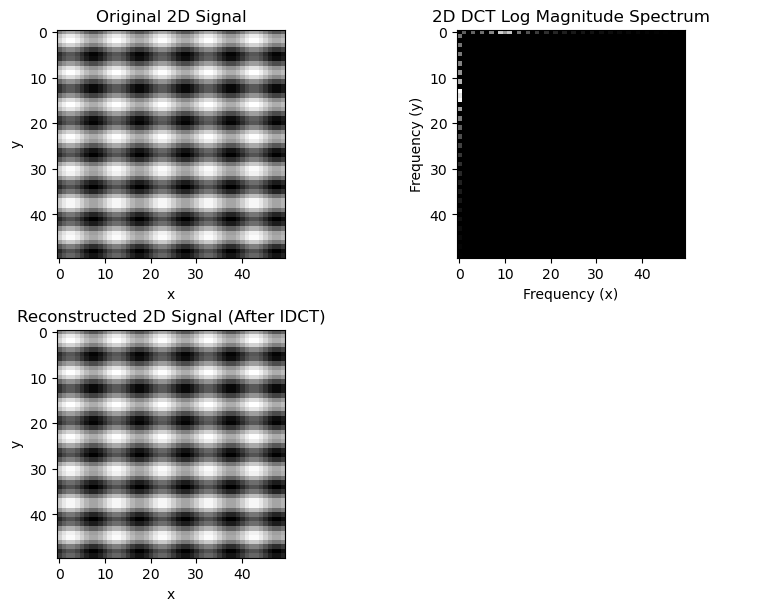

In [17]:
# plot the results
fig, axs = plt.subplots(2, 2, figsize=(8,6), layout='constrained')

# plot the original 2D signal
axs[0,0].imshow(signal_2d, cmap='gray')
axs[0,0].set_title('Original 2D Signal')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

# Plot the magnitude spectrum of the 2D DCT (Frequency Domain)
axs[0,1].imshow(np.log(dct_magnitude + 1), cmap='gray')
axs[0,1].set_title('2D DCT Log Magnitude Spectrum')
axs[0,1].set_xlabel('Frequency (x)')
axs[0,1].set_ylabel('Frequency (y)')

# plot the recovered 2D signal after Inverse DCT
axs[1,0].imshow(recovered_signal_2d, cmap='gray')
axs[1,0].set_title('Reconstructed 2D Signal (After IDCT)')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')

# Turn off the fourth subplot
axs[1,1].axis('off')

# show the figure
plt.show()

:::{important}
The standard display for DCT spectrums differs from that of the DFT in both appearance and purpose. In a typical DCT, the low-frequency components (which represent the majority of the signal's energy) are concentrated in the top-left corner of the spectrum. As you move farther from the origin (top-left corner), the frequencies increase.
:::

## Hadamard-Walsh Transform

:::{danger} TODO
Implement the normalization factor into the Hadamard matrix definition.
:::

The [HWT](wiki:Hadamard_transform) is similar to the DFT and DCT; however, instead of using sine and cosine functions it uses sequences of orthogonal square waves.

### Hadamard Transform

The Hadamard transform is a linear transformation, defined in [Definition (%s)](#def-HT) based on the Hadamard matrix, which is a matrix composed of $+1$ and $-1$ with the following properties:

- The rows and columns are orthogonal to each other
- The matrix is recursively built using smaller matrices through the Kronecker product

:::{important}
The smallest Hadamard matrix is $H_2$:

\begin{equation*}
H_2 = 
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\end{equation*}
:::

Larger Hadamard matrices, like $H_4$ are constructed as:

$$
\begin{equation*}
H_4 = H_2 \otimes H_2 = 
\begin{bmatrix}
  h_{11}H_2 & h_{12}H_2 \\
  h_{21}H_2 & h_{22}H_2
\end{bmatrix} =
\begin{bmatrix}
  1 & 1 & 1 & 1 \\
  1 & -1 & 1 & -1 \\
  1 & 1 & -1 & -1 \\
  1 & -1 & -1 & 1
\end{bmatrix}
\end{equation*}
$$

:::{prf:definition} Hadamard Transform
:label: def-HT
$$
\begin{equation*}
F = \frac{1}{N^2}H_{n \times n} \cdot x \cdot H_{n \times n}^{T}
\end{equation*}
$$

where,

- $F$ is the transformed signal (in the Hadamard domain)
- $x$ is the input signal (or input image for the 2D case)
- $H_{n /times n}$ is the Hadamard matrix of size $n \times n$
- $\frac{1}{N^2}$ is a scaling factor based on the size of the matrix
:::

Hadamard matrices can be constructed using the [scipy.linalg.hadamard](#card-hadamard) function.

In [18]:
# generate a Hadamard matrix of size 8 x 8
n = 8 # must be a power of 2
H = hadamard(n)

# print the matrix
print(H)

[[ 1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1 -1 -1  1 -1  1  1 -1]]


The 2D Hadamard transform, defined in [Definition (%s)](#def-2DHT), is an extension of the Hadamard transform.

The original image can be reconstructed using the Inverse Hadamard Transform, defined in [Definition (%s)](#def-2DIHT).

:::{prf:definition} 2D Hadamard Transform
:label: def-2DHT
$$
\begin{equation*}
F = \frac{1}{N \times M}H_{n \times n} \cdot x \cdot H_{m \times m}^{T}
\end{equation*}
$$

where,

- $N \times M$ is the size of the 2D input image
- $H_{n /times n}$ and $H_{m \times m}$ are the Hadamard matrices applied to the rows and columns of the input, respectively
- The Hadamard transform is applied to the rows first (with $H_{n \times n}$) and then to the columns (with $H_{m \times m}^{T}$)
:::

:::{prf:definition} Inverse 2D Hadamard Transform
:label: def-2DIHT
$$
\begin{equation*}
x = \frac{1}{N \times M} H_{n \times n}^{T} \cdot F \cdot H_{m \times m}^{T}
\end{equation*}
$$

where,

- $x$ is the original 2D signal (or input image)
- $F$ is the transformed 2D signal (in the Hadamard domain)
- $H_{n \times n}$ is the Hadamard matrix applied to the rows (size $n \times n$)
- $H_{m \times m}$ is the Hadamard matrix applied to the columns (size $m \times m$)
- $\frac{1}{N \times M}$ is a scaling factor based on the size of the original 2D image ($N \times M$)
:::

### Example

Create a 4x5 binary image where each pixel is randomly assigned either 0 or 1. Pad the image to make its dimensions 8x8, since the Hadamard Transform requires dimensions that are a power of two.

Apply the 2D Hadamard transform to the padded image by computing the Hadamard matrix for both the rows and the columns, then normalize the resulting matrix. Once the transform is complete, apply the 2D Inverse Hadamard Transform to reconstruct the original padded image. Finally, display both the padded image and the transformed image (Hadamard Transform result), along with the reconstructed image to verify the accuracy of the transformation.

The problem should demonstrate both the forward Hadamard Transform and the inverse transform for image reconstruction.

### Solution

Create the original image.

In [19]:
# set the seed for reproducible results
np.random.seed(42)

# Create a 4x5 matrix of random 1's and 0's
img = np.random.randint(0, 2, (4, 5))  # Randomly select between 0 and 1

Apply padding to the image since the image dimensions must be a power of 2.

In [20]:
# get the size of the image
N, M = img.shape

# image dimensions must have dimensions that are a power of 2
pad_rows = 8 - N
pad_cols = 8 - M

# apply the padding
img_padded = np.pad(img, ((0, pad_rows), (0, pad_cols)), mode='constant')

Create the Hadamard matrices.

In [21]:
# get the padding shape (i.e., 8 x 8)
N_pad, M_pad = img_padded.shape

# create the Hadamard matrices
H_n = hadamard(N_pad)
H_m = hadamard(M_pad)

Apply the Hadamard matrices to the rows and columns and normalize to get the result.

In [22]:
# apply to the rows of the image
H_rows = np.dot(H_n, img_padded)

# apply to the columns of the image
H_cols = np.dot(H_rows, H_m.T)

# normalize to get the result
HT = H_cols / (N * M)

Recreate the original image.

In [23]:
# reconstruct the original image, apply the Hadamard transform again
H_inv_rows = np.dot(H_n, HT)
H_inv_cols = np.dot(H_inv_rows, H_m.T)

# Normalize again to reconstruct the original image
reconstructed_img = H_inv_cols * (N * M)

# Remove the padding to get back the original image dimensions
reconstructed_img_cropped = reconstructed_img[:N, :M]

Plot the results.

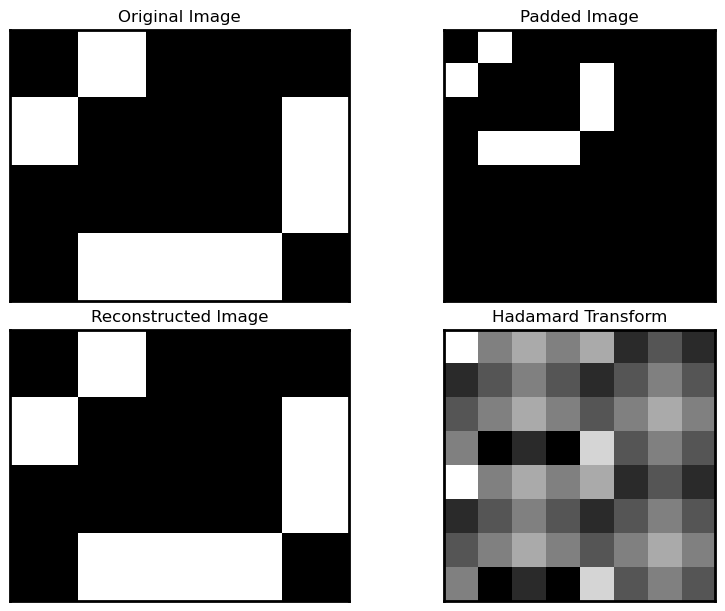

In [24]:
# plot the results
fig, axs = plt.subplots(2, 2, figsize=(8,6), layout='constrained')

# plot the original 2D signal
axs[0,0].imshow(img, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,0].spines[:].set_visible(True)
axs[0,0].spines[:].set_color('black')
axs[0,0].spines[:].set_linewidth(2)

# Plot the padded image
axs[0,1].imshow(img_padded, cmap='gray')
axs[0,1].set_title('Padded Image')

# plot the Hadamard Transform
axs[1,1].imshow(HT, cmap='gray')
axs[1,1].set_title('Hadamard Transform')

# Plot the reconstructed image
axs[1,0].imshow(reconstructed_img_cropped, cmap='gray')
axs[1,0].set_title('Reconstructed Image')

# format the axes
for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
    ax.spines[:].set_visible(True)
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# show the figure
plt.show()

The Hadamard Transform successfully converts the original image into a frequency-like domain, represented by varying grayscale intensities in the Hadamard Transform plot. The inverse transformation accurately reconstructs the original image, demonstrating the invertibility and reliability of the process. Padding the image to a size compatible with the Hadamard Transform (8x8) does not affect the core content of the image, as seen in the reconstructed output. The Hadamard domain provides insight into the image's structure based on the coefficients associated with different Hadamard basis functions. Overall, this transformation preserves the information in the image while offering a different perspective for analyzing its content.

### Walsh-Hadamard Transform

The Walsh-Hadamard Transform, defined in [Definition (%s)](#def-WHT), is based on Walsh functions which are orthogonal functions that take values 1 or -1. The Walsh-Hadamard Transform decomposes a signal into Walsh functions.

The Walsh-Hadamard Transform is similar to the Hadamard Transform, but the ordering of the rows is different.

:::{prf:definition} Walsh-Hadamard Transform
:label: def-WHT
$$
\begin{equation*}
F = \frac{1}{N \times M}W_{n \times n} \cdot x \cdot W_{m \times m}^{T}
\end{equation*}
$$

where,

- $N \times M$ is the size of the 2D input image
- $W_{n \times n}$ and $W_{m \times m}$ are the Walsh matrices applied to the rows and columns of the input, respectively
- The Walsh-Hadamard transform is applied to the rows first (with $W_{n \times n}$) and then to the columns (with $W_{m \times m}^{T}$)
The Walsh matrix can be derived from the Hadamard matrix by reordering its rows according to sequency (sign changes). The smallest Walsh matrix, $W_2$, is the same as the Hadamard matrix $H_2$, but larger Walsh matrices are reordered versions of their corresponding Hadamard matrices.

The **Hadamard matrix** $H_4$ is given by:

$$
H_4 = \frac{1}{\sqrt{4}} \begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & -1 & 1 & -1 \\
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1
\end{bmatrix}
$$

To create the Walsh matrix $W_4$, we reorder the rows based on their **sequency** (the number of sign changes in each row):

$$
W_4 = \frac{1}{\sqrt{4}} \begin{bmatrix}
1 & 1 & 1 & 1 \quad \text{(sequency 0)} \\
1 & 1 & -1 & -1 \quad \text{(sequency 1)} \\
1 & -1 & 1 & -1 \quad \text{(sequency 2)} \\
1 & -1 & -1 & 1 \quad \text{(sequency 3)}
\end{bmatrix}
$$

In [25]:
def count_sign_changes(row):
    """Counts the number of sign changes in a row."""
    return np.sum(np.diff(row) != 0)

# Generate a Hadamard matrix of size 8 x 8
n = 8
H = hadamard(n)

# Count the number of sign changes in each row of the Hadamard matrix
sign_changes = np.array([count_sign_changes(row) for row in H])

# Generate the sequency order by sorting rows based on sign changes
sequency_order = np.argsort(sign_changes)

# Reorder the rows of the Hadamard matrix to get the Walsh matrix
W = H[sequency_order, :]

# Print the Walsh matrix
print(W)

[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1 -1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]]


:::{danger} TODO
Example of WHT
:::

## Haar Transform

### Wavelets

A wavelet[^wavelet] is a mathematical function used to divide a signal into different frequency components, but unlike Fourier-based methods which only show frequencies, wavelets are localized in time and frequency.

Wavelets offer a powerful way to analyze signals and images, particularly when features of interest are localized in time or space. Their multi-resolution nature allows for efficient compression and feature extraction, making them invaluable in a wide range of applications in signal processing and computer vision.

#### Key Characteristics

- __Localized in time and frequency__

    A wavelet is a short oscillating function that has a finite duration, meaning it is localized in time. It can capture both high-frequency details (e.g., edges in images) and low-frequency trends (e.g., smooth regions) within a signal. This contrasts with sinusoids used in Fourier transforms, which are not localized in time but only in frequency.

- __Multi-Resolution Analysis__

    Wavelets allow you to zoom into a signal at different scales or resolutions. This is useful when you want to examine finer details at higher resolutions or identify trends over larger scales at lower resolutions. This multi-resolution capability makes wavelets powerful for applications like image compression, denoising, and edge detection.

- __Mother Wavelet__

    A wavelet family is generated from a single base function called the mother wavelet. By scaling and translating the mother wavelet, you create different "daughter" wavelets that analyze the signal at various levels. Scaling the wavelet compresses or stretches it, allowing it to capture different frequencies. Translating the wavelet shifts it in time, allowing it to focus on different parts of the signal.

### Haar Wavelet

[^wavelet]: Wavelet transform is an invaluable tool in signal processing, which has applications in a variety of fields - from hydrodynamics to neuroscience. This revolutionary method allows us to uncover structures, which are present in the signal but are hidden behind the noise. The key feature of wavelet transform is that it performs function decomposition in both time and frequency domains.

    :::{iframe} https://www.youtube.com/embed/jnxqHcObNK4?si=iUPi6lTJYyGVVTW_
    :width: 100%
    Wavelets: a mathematical microscope
    :::

The [Haar wavelet](wiki:Haar_wavelet) is a real-valued discontinuous wavelet that is piecewise constant. It is one of the simplest wavelets, defined by a step function that takes on values of 1 and -1, with no oscillatory or complex components. Haar wavelets are used for edge detection, object recognition, and signal denoising. The wavelet is defined in [Definition (%s)](#def-haar_wavelet).

:::{prf:definition} Haar Wavelet
:label: def-haar_wavelet
$$
\begin{equation*}
\psi(t) = 
\begin{cases} 
1 & 0 \leq t < \frac{1}{2} \\
-1 & \frac{1}{2} \leq t < 1 \\
0 & \text{otherwise}
\end{cases}
\end{equation*}
$$
:::

We can define a function to represent the Haar wavelet.

In [8]:
# Define the Haar wavelet function
def haar_wavelet(t):
    # Haar wavelet is defined as 1 for 0 <= t < 0.5, -1 for 0.5 <= t < 1, and 0 elsewhere
    return np.where((0 <= t) & (t < 0.5), 1, np.where((0.5 <= t) & (t < 1), -1, 0))

Then apply the wavelet to a time vector.

In [9]:
# Create a time vector from -0.5 to 1.5 (to show the zero regions clearly)
t = np.linspace(-0.5, 1.5, 500)

# Get the Haar wavelet values for each time point
haar_values = haar_wavelet(t)

Plot the wavelet.

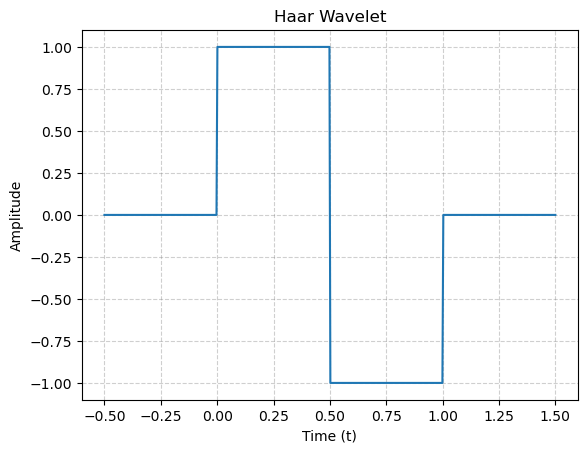

In [10]:
# Plot the Haar Wavelet
fig, ax = plt.subplots()
ax.plot(t, haar_values)
ax.set_title('Haar Wavelet')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Amplitude')
ax.grid(True, linestyle='--', color='gray', alpha=0.375)
plt.show()

:::{danger} TODO
1D Wavelet example
:::

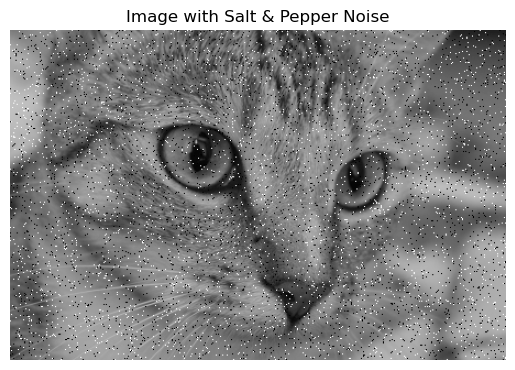

In [7]:
# Load an example image from scikit-image
img = skimage.data.cat()  # RGB image
img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Add salt and pepper noise to the image
noisy_image = skimage.util.random_noise(img_gray, mode='s&p', amount=0.05)

# Convert the noisy image to 8-bit unsigned byte format for visualization
noisy_image = skimage.img_as_ubyte(noisy_image)

# Plot the noisy images
fig, ax = plt.subplots()
ax.imshow(noisy_image, cmap='gray')
ax.set_title('Image with Salt & Pepper Noise')
ax.axis('off')

plt.show()

:::{danger} TODO
create an example removing salt and pepper noise
:::